In [31]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MaxAbsScaler 
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, ConfusionMatrixDisplay, roc_auc_score, classification_report, accuracy_score, precision_recall_curve, precision_score, recall_score,  f1_score
# Ahora hacemos la agrupación con el segundo modelo, el Support Vector Machine
from sklearn import svm
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier
from tabulate import tabulate
import gensim # take text for clean and tokenize list of words
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
import nltk
nltk.download('stopwords') #language package for english
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import re
from sklearn.feature_extraction.text import CountVectorizer

In [2]:
without_outliers= pd.read_csv('complete_without_outliers.csv')

### Limpieza

In [4]:
stop_words = list(stopwords.words("english"))

In [5]:
# Inicializamos PorterStemmer
ps = PorterStemmer()

# Cargamos las stopwords en inglés
stop_words = set(stopwords.words('english'))

# Función para limpiar y procesar el texto
def limpiar_texto(text):
    # Verificar si el texto no es nulo o vacío
    if isinstance(text, str):
        # Eliminar saltos de línea y múltiples espacios
        text = re.sub(r'\s+', ' ', text)  # Reemplaza saltos de línea y tabs por un espacio
        text = text.strip()  # Elimina espacios en blanco iniciales y finales

        # Convertir a palabras en minúsculas y filtrar stopwords
        words = [
            ps.stem(word) for word in gensim.utils.simple_preprocess(text)
            if word not in gensim.parsing.preprocessing.STOPWORDS and word not in stop_words
        ]
        return ' '.join(words)
    else:
        return None  # Devuelve None si el texto es inválido

# Aplicar la función de limpieza al DataFrame
without_outliers['text_cleaned'] = without_outliers['text'].apply(limpiar_texto)

# Eliminar filas donde el texto limpio es None o vacío
df_complete = without_outliers[without_outliers['text_cleaned'].notnull() & (without_outliers['text_cleaned'] != '')]

# Reiniciar el índice del DataFrame después de eliminar las filas
df_complete.reset_index(drop=True, inplace=True)

In [7]:
X = without_outliers["text_cleaned"]
y = without_outliers["class"]

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

### Vectorización

In [10]:
 # usamos CountVectorizer

vect = CountVectorizer()
X_train_dtm = vect.fit_transform(X_train) # dtm as document-term matrix
X_test_dtm = vect.transform(X_test)

### Normalizamos

In [17]:
# Normalizamos
Norm = MaxAbsScaler()
X_train_norm= Norm.fit_transform(X_train_dtm)
X_test_norm = Norm.transform(X_test_dtm)

## Machine learning models

### Naive Bayes

In [18]:
nb_model = MultinomialNB().fit(X_train_norm, y_train)
# hacemos la predicción 
pred_nb_model= nb_model.predict(X_test_norm)

In [19]:
# obtenemos la precisión de nuestro modelo, accuracy
accuracy_nb=nb_model.score(X_test_norm, y_test)
accuracy_nb

0.6891806454216495

In [20]:
# obtenemos la descomposición de la precisión, en sus tres variantes (precision, recall, f1score)
# Metrics for NB
print(classification_report(y_test, pred_nb_model))

              precision    recall  f1-score   support

           0       0.68      0.71      0.70     37075
           1       0.70      0.67      0.68     37264

    accuracy                           0.69     74339
   macro avg       0.69      0.69      0.69     74339
weighted avg       0.69      0.69      0.69     74339



<Figure size 800x400 with 0 Axes>

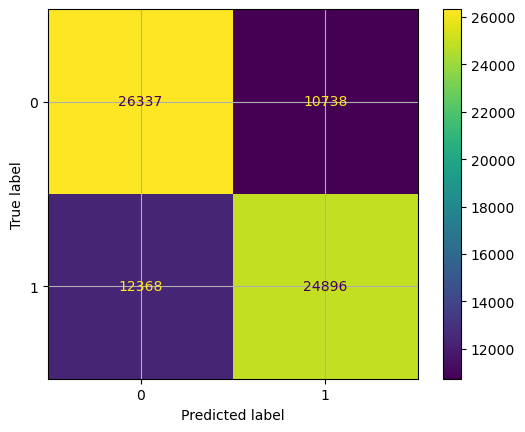

In [21]:
# obtenemos la matriz de decisión del primer modelo

matriz1=confusion_matrix(y_test, pred_nb_model)
matriz1
disp = ConfusionMatrixDisplay(confusion_matrix=matriz1)
plt.figure(figsize=(8, 4))
disp.plot(cmap='viridis')  
plt.grid(True)
plt.show()

### Support Vector Machine

In [22]:
SS = svm.LinearSVC()
# Para hacer la posterior representación de la curva de ROC, necesitamos obtener las probabilidades, y para ello usamos
# la función CalibratedClassifier
clf_svm = CalibratedClassifierCV(estimator=SS) 
# Ajustamos el modelo y realizamos la predicción
svm_model=clf_svm.fit(X_train_norm, y_train)
pred_svm_model=svm_model.predict(X_test_norm)

In [23]:
# Descomposición de la precisión del segundo modelo
print(classification_report(y_test, pred_svm_model))

              precision    recall  f1-score   support

           0       0.91      0.91      0.91     37075
           1       0.91      0.91      0.91     37264

    accuracy                           0.91     74339
   macro avg       0.91      0.91      0.91     74339
weighted avg       0.91      0.91      0.91     74339



### X-Gboost

In [24]:
# Crear y ajustar el modelo XGBoost para clasificación
xgboost_model = XGBClassifier()
xgboost_model.fit(X_train_norm, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [25]:
# Hacer predicciones
pred_xgboost_model = xgboost_model.predict(X_test_norm)

In [26]:
# Evaluación del modelo
accuracy_boost = accuracy_score(y_test, pred_xgboost_model)
print("Accuracy:", accuracy_boost)

Accuracy: 0.8981288421958864


In [27]:
# Metrics for Xgboost
print(classification_report(y_test, pred_xgboost_model))

              precision    recall  f1-score   support

           0       0.91      0.88      0.90     37075
           1       0.88      0.92      0.90     37264

    accuracy                           0.90     74339
   macro avg       0.90      0.90      0.90     74339
weighted avg       0.90      0.90      0.90     74339



In [28]:

# Para hacer la comparativa con la curva de ROC, primero tenemos que obtener las probabilidades y después obtenemos los scores

y_score1 = nb_model.fit(X_train_norm, y_train).predict_proba(X_test_norm)[:,1]
y_score2 = svm_model.fit(X_train_norm, y_train).predict_proba(X_test_norm)[:,1]
y_score3 = xgboost_model.fit(X_train_norm, y_train).predict_proba(X_test_norm)[:,1]

false_positive_rate1, true_positive_rate1, threshold1 = roc_curve(y_test, y_score1)
false_positive_rate2, true_positive_rate2, threshold2 = roc_curve(y_test, y_score2)
false_positive_rate3, true_positive_rate3, threshold3 = roc_curve(y_test, y_score3)

roc1=roc_auc_score(y_test, y_score1)
roc2=roc_auc_score(y_test, y_score2)
roc3=roc_auc_score(y_test, y_score3)

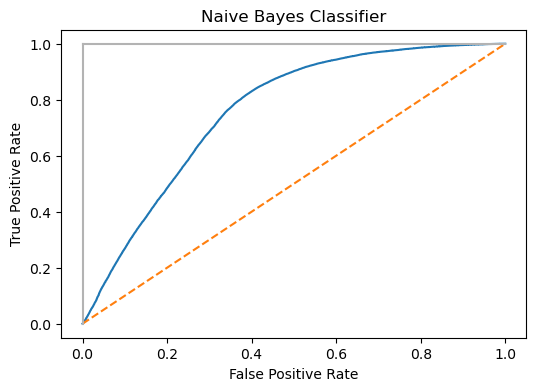

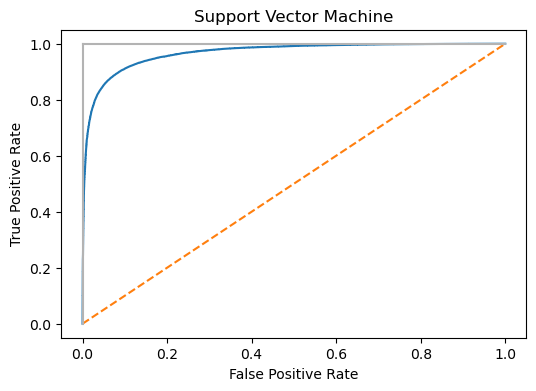

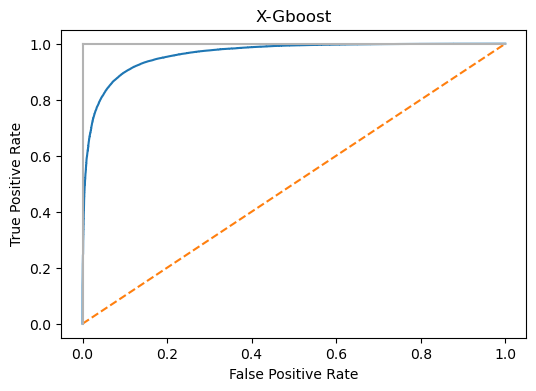

In [29]:
# Graficamos los valores de la curva ROC
plt.subplots(1, figsize=(6,4))
plt.title('Naive Bayes Classifier')
plt.plot(false_positive_rate1, true_positive_rate1)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()
plt.subplots(1, figsize=(6,4))
plt.title('Support Vector Machine')
plt.plot(false_positive_rate2, true_positive_rate2)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()
plt.subplots(1, figsize=(6,4))
plt.title('X-Gboost')
plt.plot(false_positive_rate3, true_positive_rate3)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [32]:
# Tabla resumen y comparativa entre la precisión y la curva ROC de los dos modelos

precision_mod1=precision_score(y_test, pred_nb_model, average='weighted')
precision_mod2=precision_score(y_test, pred_svm_model, average='weighted')
precision_mod3=precision_score(y_test, pred_xgboost_model, average='weighted')

recall_mod1=recall_score(y_test, pred_nb_model, average='weighted')
recall_mod2=recall_score(y_test, pred_svm_model, average='weighted')
recall_mod3=recall_score(y_test, pred_xgboost_model, average='weighted')

f1_mod1=f1_score(y_test, pred_nb_model, average='weighted')
f1_mod2=f1_score(y_test, pred_svm_model, average='weighted')
f1_mod3=f1_score(y_test, pred_xgboost_model, average='weighted')

summary1=[[precision_mod1,recall_mod1,f1_mod1,roc1],[precision_mod2,recall_mod2,f1_mod2,roc2],[precision_mod3,recall_mod3,f1_mod3,roc3]]
encabezado=['Ratios','Precision','Recall','F1 Score','ROC/AUC']
indice=['Naive Bayes','SVM', 'X-Gboost']
print(tabulate(summary1, headers=encabezado,showindex=indice, tablefmt='fancy_grid'))

╒═════════════╤═════════════╤══════════╤════════════╤═══════════╕
│ Ratios      │   Precision │   Recall │   F1 Score │   ROC/AUC │
╞═════════════╪═════════════╪══════════╪════════════╪═══════════╡
│ Naive Bayes │    0.68958  │ 0.689181 │   0.689048 │  0.758877 │
├─────────────┼─────────────┼──────────┼────────────┼───────────┤
│ SVM         │    0.906147 │ 0.906146 │   0.906146 │  0.967033 │
├─────────────┼─────────────┼──────────┼────────────┼───────────┤
│ X-Gboost    │    0.898651 │ 0.898129 │   0.89809  │  0.963714 │
╘═════════════╧═════════════╧══════════╧════════════╧═══════════╛


Los resultados del mejor modelo en este caso es SVM pero es muy similar a X-Gboost